<a href="https://colab.research.google.com/github/His-seer/Machine-Learning/blob/main/pneumonia_vit_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import sys
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.image import extract_patches

from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import AdamW
from keras import Input, Model
from keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import cv2

sns.set_style('darkgrid')

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import random

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Preparing data

In [4]:
DATA_ROOT = '/content/drive/MyDrive/Colab Notebooks/chest_xray'

DATA_TRAIN = os.path.join(DATA_ROOT, "train")
# DATA_VALID = os.path.join(DATA_ROOT, "val")
DATA_TEST  = os.path.join(DATA_ROOT, "test")

LABELS = ['NORMAL', 'PNEUMONIA']
IMAGE_SIZE = (224, 224)
PATCH_SIZE = 16
BATCH_SIZE = 32

In [5]:
def get_datasource(*data_dirs, flag=cv2.IMREAD_GRAYSCALE):
    x, y = list(), list()
    for data_dir in data_dirs:
        for i, label in enumerate(LABELS):
            path = os.path.join(data_dir, label)
            target = [0] * len(LABELS)
            target[i] = 1
            for img in os.listdir(path):
                if img.endswith(".jpeg"):
                    img_arr = cv2.imread(os.path.join(path, img), flag)
                    resized_arr = cv2.resize(img_arr, IMAGE_SIZE)
                    x.append(resized_arr)
                    y.append(target)
    return np.array(x) / 255, np.array(y)

Image data are loaded as grayscale pictures. Data for training set are joined from `train` and `val` directories respectively.

In [6]:
x_train, y_train = get_datasource(DATA_TRAIN)
x_test, y_test = get_datasource(DATA_TEST)

x_train = np.expand_dims(x_train, axis=-1)
x_test  = np.expand_dims(x_test, axis=-1)

I will use the data augmentation layers arranged at the top of the model:

In [7]:
data_augmentation = keras.Sequential([
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ], name="data_augmentation")

data_augmentation.layers[0].adapt(x_train)

In [ ]:
# y_train = np.array([y for x, y in image_dataset_from_directory(DATA_TRAIN, label_mode='categorical', class_names=['NORMAL', 'PNEUMONIA'], batch_size=None).as_numpy_iterator()])
# class_weight = compute_class_weight('balanced', classes=np.unique(y_train).astype(int), y=y_train[:,1].astype(int))
# class_weight = {i:v for i,v in enumerate(class_weight)}

# Model Evaluation Framework

For model performance evaluation I will use a standardised approach implemented in this procedure:

In [8]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

def evaluate_model(model, *, epochs=5, batch_size=32, forced_training=False):

    print(f"=== MODEL EVALUATION =================================================\n")

    optimizer = AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
    model.summary()

    MODEL_CHECKPOINT = f"/kaggle/working/model/{model.name}.ckpt"

    if not os.path.exists(MODEL_CHECKPOINT) or forced_training:
        print(f"\n--- Model training ---------------------------------------------------\n")

        shutil.rmtree(MODEL_CHECKPOINT, ignore_errors=True)

        callbacks_list = [
            keras.callbacks.EarlyStopping(
                monitor='val_auc',
                patience=10),
            keras.callbacks.ModelCheckpoint(
                filepath=MODEL_CHECKPOINT,
                monitor='val_auc',
                save_best_only=True,
                mode='max',
                verbose=1)
        ]
        history = model.fit(
            x=x_train,
            y=y_train,
            epochs=epochs,
            callbacks=callbacks_list,
#             class_weight=class_weight,
            validation_split=0.2,
            verbose=1)

        print(f"\n--- Training history -------------------------------------------------\n")

        fig, ax = plt.subplots(1, 2, figsize=(16, 4))
        sns.lineplot(data={k: history.history[k] for k in ('loss', 'val_loss')}, ax=ax[0])
        sns.lineplot(data={k: history.history[k] for k in history.history.keys() if k not in ('loss', 'val_loss')}, ax=ax[1])
        plt.show()

    else:
        print(f"\n--- Model is already trainded ... loading ----------------------------\n")

    model.load_weights(MODEL_CHECKPOINT)

    print(f"\n--- Test Predictions and Metrics -------------------------------------\n")

    y_pred = model.predict(x_test, verbose=0)

    plt.figure(figsize=(6, 3))
    heatmap = sns.heatmap(confusion_matrix(np.argmax(y_test, axis=-1),  np.argmax(y_pred, axis=-1)), annot=True, fmt="d", cbar=True)
    heatmap.yaxis.set_ticklabels(LABELS, rotation=90, ha='right')
    heatmap.xaxis.set_ticklabels(LABELS, rotation=0, ha='right')
    heatmap.axes.set_ylabel('True label')
    heatmap.axes.set_xlabel('Predicted label')
    plt.show()

    print()
    print(classification_report(np.argmax(y_test, axis=-1), np.argmax(y_pred, axis=-1), target_names=LABELS, zero_division=0))

    print(f"\n=== MODEL EVALUATION FINISHED ========================================")

    return y_pred

# ViT Model trained from the scratch

This chapter comtains implementation of the Visual Transoformer from the scratch.

This is how the patch extraction layer looks like:

In [9]:
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):

        patches = extract_patches(images=images,
                                  sizes=[1, self.patch_size, self.patch_size, 1],
                                  strides=[1, self.patch_size, self.patch_size, 1],
                                  rates=[1, 1, 1, 1],
                                  padding='VALID')
        b = tf.shape(patches)[0]
        h = tf.shape(patches)[1]
        w = tf.shape(patches)[2]
        p = tf.shape(patches)[3]
        return tf.reshape(patches, (b, h * w, p))

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

For better notion how patch extraction works:

In [13]:
patches = Patches(PATCH_SIZE)(x_test)

(-0.5, 223.5, 223.5, -0.5)

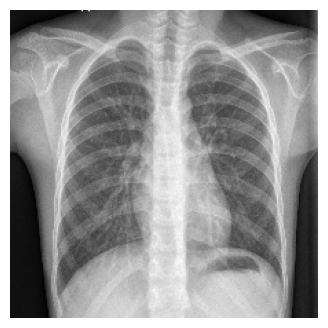

In [12]:
plt.figure(figsize=(4, 4))
image = x_test[0]*255.
plt.imshow((image).astype("uint8"), cmap='gray')
plt.axis("off")

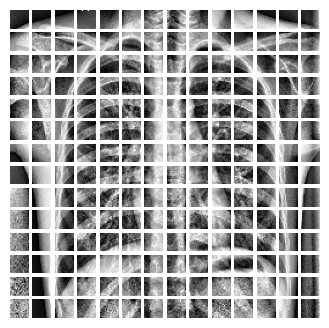

In [14]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0].numpy()):
    ax = plt.subplot(n, n, i + 1)
    patch *= 255.
    patch_img = patch.reshape((PATCH_SIZE, PATCH_SIZE, 1))
    plt.imshow(patch_img.astype("uint8"), cmap='gray')
    plt.axis("off")
plt.show()

Layer for projecting patches and their possitions to multi-dimensional vectors.

In [15]:
class PatchEncoder(layers.Layer):
    def __init__(self, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.patches = input_shape[-2]
        self.projection = layers.Dense(units=self.projection_dim)
        self.position_embedding = layers.Embedding(input_dim=self.patches, output_dim=self.projection_dim)

    def call(self, patch):
        projected = self.projection(patch);
        encoded = self.position_embedding(np.expand_dims(np.arange(0, self.patches), axis=0))
        return projected + encoded

    def get_config(self):
        config = super().get_config()
        config.update({"projection_dim": self.projection_dim})
        return config

And there is the core of the model:

In [16]:
PROJECTION_DIMENSION = 64

ATTENTION_HEADS = 4
TRANSFORMER_LAYERS = 8
TRANSFORMER_UNITS = [
    PROJECTION_DIMENSION * 2,
    PROJECTION_DIMENSION,
]
MLP_HEAD_UNITS = [1024, 512]


def create_model_ViT(X_shape, classes=2, name="ViT"):

    def mlp(x, hidden_units, dropout_rate=0.3, name=""):
        for i, units in enumerate(hidden_units):
            x = layers.Dense(units, activation=keras.activations.gelu, name=f"{name}_{i}_dense")(x)
            x = layers.Dropout(dropout_rate, name=f"{name}_{i}_dropout")(x)
        return x

    inputs = layers.Input(X_shape[-3:], name='inputs')

    augmented = data_augmentation(inputs)

    patches = Patches(PATCH_SIZE, name=f'patches')(augmented)
    encoded_patches = PatchEncoder(PROJECTION_DIMENSION, name=f'patch_encoder')(patches)

    for i in range(TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6, name=f"normalization_a_{i}")(encoded_patches)
        attention_output  = layers.MultiHeadAttention(
            num_heads=ATTENTION_HEADS,
            key_dim=PROJECTION_DIMENSION,
            dropout=0.1,
            name=f"multihead_attention_{i}"
        )(x1, x1)
        x2 = layers.Add(name=f"skip_a_{i}")([attention_output , encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6, name=f"normalization_b_{i}")(x2)
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1, name=f"mlp_{i}")
        encoded_patches = layers.Add(name=f"skip_b_{i}")([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6, name=f"representation_norm")(encoded_patches)
    representation = layers.Flatten(name=f"representation_flatten")(representation)
    representation = layers.Dropout(0.5, name="representation_dropout")(representation)

    x = mlp(representation, MLP_HEAD_UNITS, name="dense")
    outputs = layers.Dense(classes, activation='softmax', name='outputs')(x)

    return Model(inputs=inputs, outputs=outputs, name=name)

Model evaluation procedure:

In [ ]:
y_pred = evaluate_model(create_model_ViT(x_train.shape, 2), forced_training=True)

=== MODEL EVALUATION =================================================

Model: "ViT"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 224, 224, 1)          3         ['inputs[0][0]']              
 ial)                                                                                             
                                                                                                  
 patches (Patches)           (None, 196, 256)             0         ['data_augmentation[0][0]']   
                                                                                                  
 patch_encoder (PatchEnc

In [ ]:
!pip install vit-keras

  Obtaining dependency information for validators from https://files.pythonhosted.org/packages/3a/0c/785d317eea99c3739821718f118c70537639aa43f96bfa1d83a71f68eaf6/validators-0.22.0-py3-none-any.whl.metadata


In [ ]:
from vit_keras import vit

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


I am loading data as RGB images.

In [ ]:
x_train, y_train = get_datasource(DATA_TRAIN, DATA_VALID, flag=cv2.IMREAD_COLOR)
x_test, y_test = get_datasource(DATA_TEST, flag=cv2.IMREAD_COLOR)

data_augmentation = keras.Sequential([
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ], name="data_augmentation")

data_augmentation.layers[0].adapt(x_train)

And there is the model. I will use Base16 model as the base for my transfre learning. It is supplemented by MLP and Dense layers.

In [ ]:
def create_model_ViTTrans(X_shape, classes=2, name="ViTTrans"):

    def mlp(x, hidden_units, activation='relu', dropout_rate=0.3, name=""):
        for i, units in enumerate(hidden_units):
            x = layers.Dense(units, activation=activation, name=f"{name}_{i}_dense")(x)
            x = layers.Dropout(dropout_rate, name=f"{name}_{i}_dropout")(x)
        return x

    base_model = vit.vit_b16(image_size=IMAGE_SIZE, include_top=False, pretrained_top=False)
    base_model.trainable = False

    inputs = Input(X_shape[-3:], name='inputs')

    x = base_model(inputs, training=False)

#     x = layers.GlobalAveragePooling2D(name=f"global_average")(x)

    x = mlp(x, (1024, 512), name="dense")
    outputs = layers.Dense(classes, activation='softmax', name='outputs')(x)

    return Model(inputs=inputs, outputs=outputs, name=name)

And finally evaluation of the model:

347502902/347502902 [==============================] - 11s 0us/step


/opt/conda/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


=== MODEL EVALUATION =================================================

Model: "ViTTrans"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dense_0_dense (Dense)       (None, 1024)              787456    
                                                                 
 dense_0_dropout (Dropout)   (None, 1024)              0         
                                                                 
 dense_1_dense (Dense)       (None, 512)               524800    
                                                                 
 dense_1_dropout (Dropout)   (None, 512)               0         
                                                    

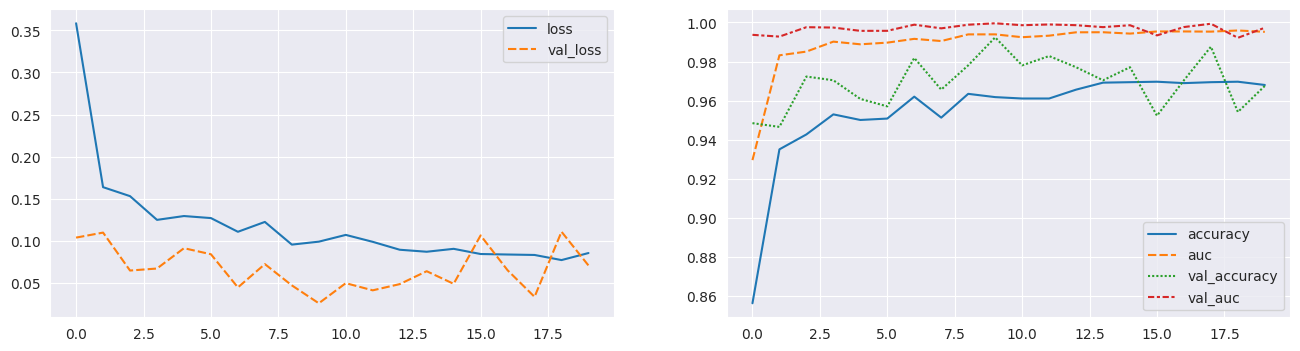


--- Test Predictions and Metrics -------------------------------------



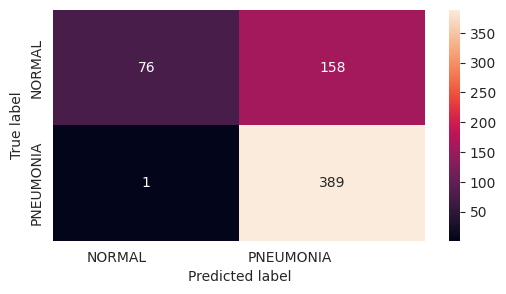


              precision    recall  f1-score   support

      NORMAL       0.99      0.32      0.49       234
   PNEUMONIA       0.71      1.00      0.83       390

    accuracy                           0.75       624
   macro avg       0.85      0.66      0.66       624
weighted avg       0.81      0.75      0.70       624


=== MODEL EVALUATION FINISHED ========================================


In [ ]:
y_pred = evaluate_model(create_model_ViTTrans(x_train.shape, 2), forced_training=True)